> `간단한 모델`들이 `상호 보완적인 역할`을 할 수 있도록 `단계적으로 학습을 수행하여` 결합함으로써 성능을 향상시키는 앙상블 학습 기법

- 순차적으로 학습하도록 하여, 먼저 학습된 결과가 다음 학습에 정보를 제공하여 이전의 학습의 결점을 보완하는 방향으로 학습이 반복적으로 이루어짐
- 데이터에 과적합 될 수 있는 단점

In [1]:
import pandas as pd

# data 시각화
import matplotlib
import matplotlib.pyplot as plt

# Korean pont
matplotlib.rc('font',family = 'NanumGothicCoding')

# train, test 데이터 분할 함수
from sklearn.model_selection  import train_test_split
# Grid Search
from sklearn.model_selection import GridSearchCV


from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.tree import export_graphviz
# import graphviz

## Step01 - 데이터 불러오기

In [2]:
df_raw = pd.read_csv("./data/체질검사.csv", encoding = '949')
df_raw.head()

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
0,35.2,46,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4
1,11.8,27,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8
2,22.2,69,177.75,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8
3,10.6,57,147.75,65.75,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9
4,47.5,51,219.00,64.00,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4


## Step01 - 목표변수(Y)제거 후 따로 저장, 설명변수와 목표변수 분리

In [4]:
df_raw_y = df_raw['FAT']
df_raw_x = df_raw.drop("FAT", axis = 1, inplace = False)
df_raw_x.head()

,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
0,46,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4
1,27,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8
2,69,177.75,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8
3,57,147.75,65.75,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9
4,51,219.00,64.00,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4


## Step01 - 데이터 분할

In [5]:
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y
                                                               , test_size = 0.3, random_state = 1234)
print('train data X size : {}'.format(df_train_x.shape))
print('train data Y size : {}'.format(df_train_y.shape))
print('test data X size : {}'.format(df_test_x.shape))
print('test data Y size : {}'.format(df_test_y.shape))


train data X size : (176, 13)
train data Y size : (176,)
test data X size : (76, 13)
test data Y size : (76,)


## Step02 - 모델 생성

In [6]:
gb_uncustomized = GradientBoostingRegressor(random_state = 1234)
gb_uncustomized.fit(df_train_x, df_train_y)

print('Score on trainning set : {:.3f}'.format(gb_uncustomized.score(df_train_x, df_train_y)))
print('Score on test set : {:.3f}'.format(gb_uncustomized.score(df_test_x, df_test_y)))

Score on trainning set : 0.981
Score on test set : 0.584


> test data의 설명력이 매우 낮음 : `과대적합`

## Step02 - 트리 수 변경에 다른 모델 성능

In [7]:
train_score = [];test_score=[]
para_n_tree = [n_tree * 5 for n_tree in range(1,51)]

for v_n_estimators in para_n_tree:
    gb = GradientBoostingRegressor(n_estimators = v_n_estimators, random_state = 1234)
    
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
#저장
df_score_n = pd.DataFrame()
df_score_n['Estimators'] = para_n_tree
df_score_n['TrainScore'] = train_score
df_score_n['TestScore'] = test_score

In [9]:
df_score_n.round(3).head(10)

,Estimators,TrainScore,TestScore
0,5,0.506,0.365
1,10,0.712,0.512
2,15,0.804,0.578
3,20,0.850,0.589
4,25,0.878,0.597
5,30,0.897,0.600
6,35,0.911,0.599
7,40,0.921,0.599
8,45,0.932,0.591
9,50,0.942,0.587


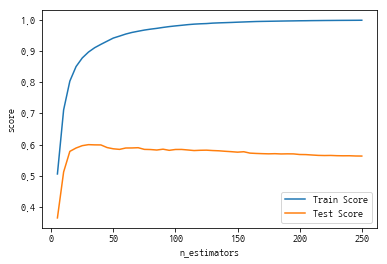

In [10]:
plt.plot(para_n_tree, train_score, linestyle = '-', label = 'Train Score')
plt.plot(para_n_tree, test_score, linestyle = '-', label = 'Test Score')
plt.ylabel('score');plt.xlabel('n_estimators')
plt.legend()

> estimators가 30개가 적당하다

## Step02 - Leaf Node 자료 수 지정

In [11]:
train_score = [];test_score=[]
para_leaf = [n_tree * 1 for n_tree in range(1,21)]

for v_min_samples_leaf in para_leaf:
    rf = GradientBoostingRegressor(random_state = 1234, n_estimators = 30,
                              min_samples_leaf = v_min_samples_leaf)
    
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))
    
#저장
df_score_leaf = pd.DataFrame()
df_score_leaf['MinSamplesLeaf'] = para_leaf
df_score_leaf['TrainScore'] = train_score
df_score_leaf['TestScore'] = test_score

In [12]:
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.897,0.600
1,2,0.899,0.596
2,3,0.896,0.595
3,4,0.893,0.586
4,5,0.890,0.604
5,6,0.888,0.596
6,7,0.884,0.590
7,8,0.874,0.610
8,9,0.879,0.598
9,10,0.873,0.587


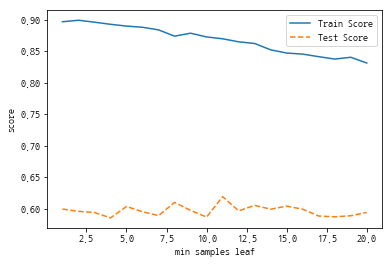

In [13]:
plt.plot(para_leaf, train_score, linestyle = '-', label = 'Train Score')
plt.plot(para_leaf, test_score, linestyle = '--', label = 'Test Score')
plt.ylabel('score');plt.xlabel('min samples leaf')
plt.legend()

> min_sampels_leaf 가 11개가 적당하다

## Step02 - 분리노드(Splite)의 최소 자료 수 변경에 따른 모델 성능

In [14]:
train_score = [];test_score=[]
para_split = [n_tree * 2 for n_tree in range(1,21)]

for v_min_samples_split in para_split:
    rf = GradientBoostingRegressor(random_state = 1234, n_estimators = 30, min_samples_leaf = 11,
                              min_samples_split = v_min_samples_split)
    
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))
    
#저장
df_score_split = pd.DataFrame()
df_score_split['MinSampleSplit'] = para_split
df_score_split['TrainScore'] = train_score
df_score_split['TestScore'] = test_score
df_score_split.round(3)

,MinSampleSplit,TrainScore,TestScore
0,2,0.870,0.620
1,4,0.870,0.620
2,6,0.870,0.620
3,8,0.870,0.620
4,10,0.870,0.620
5,12,0.870,0.620
6,14,0.870,0.620
7,16,0.870,0.620
8,18,0.870,0.620
9,20,0.870,0.620


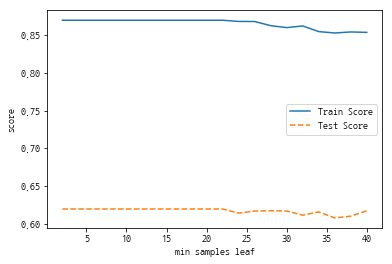

In [15]:
plt.plot(para_split, train_score, linestyle = '-', label = 'Train Score')
plt.plot(para_split, test_score, linestyle = '--', label = 'Test Score')
plt.ylabel('score');plt.xlabel('min samples leaf')
plt.legend()

> min_split 는 22개가 적당하다

## Step02 - 최대깊이 변경에 따른 모델 성능

In [18]:
train_score = [];test_score=[]
para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    gb = GradientBoostingRegressor(random_state = 1234, n_estimators = 30,
                              min_samples_leaf = 11, min_samples_split = 22,
                              max_depth = v_max_depth)
    
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
df_score_depth = pd.DataFrame()
df_score_depth['Depth'] = para_depth
df_score_depth['TrainScore'] = train_score
df_score_depth['TestScore'] = test_score
df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.703,0.592
1,2,0.800,0.600
2,3,0.870,0.620
3,4,0.900,0.629
4,5,0.913,0.613
5,6,0.917,0.614
6,7,0.920,0.613
7,8,0.920,0.615
8,9,0.921,0.609
9,10,0.922,0.616


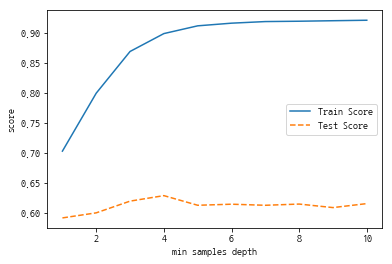

In [19]:
plt.plot(para_depth, train_score, linestyle = '-', label = 'Train Score')
plt.plot(para_depth, test_score, linestyle = '--', label = 'Test Score')
plt.ylabel('score');plt.xlabel('min samples depth')
plt.legend()

> depth 4개가 적절하다

## Step02 - 학습률 변경 시 모델의 설명력 변화

In [21]:
train_score = [];test_score=[]
para_lr = [lr * 0.1 for lr in range(1,10)]

for v_learning_rate in para_lr:
    gb = GradientBoostingRegressor(random_state = 1234, n_estimators = 30,
                              min_samples_leaf = 11, min_samples_split = 22,
                              max_depth = 4, learning_rate = v_learning_rate)
    
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
df_score_depth = pd.DataFrame()
df_score_depth['LearningRate'] = para_lr
df_score_depth['TrainScore'] = train_score
df_score_depth['TestScore'] = test_score
df_score_depth.round(3)

,LearningRate,TrainScore,TestScore
0,0.1,0.900,0.629
1,0.2,0.940,0.588
2,0.3,0.966,0.566
3,0.4,0.981,0.539
4,0.5,0.984,0.533
5,0.6,0.990,0.527
6,0.7,0.993,0.478
7,0.8,0.994,0.437
8,0.9,0.997,0.464


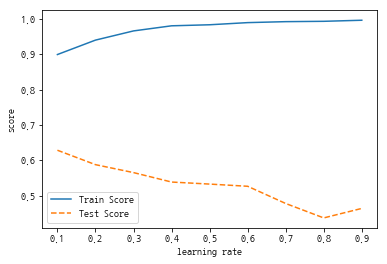

In [23]:
plt.plot(para_lr, train_score, linestyle = '-', label = 'Train Score')
plt.plot(para_lr, test_score, linestyle = '--', label = 'Test Score')
plt.ylabel('score');plt.xlabel('learning rate')
plt.legend()

> Learning Rate은 0.1이 적절합니다

## Step03 - 결론도출

In [25]:
gb_final = GradientBoostingRegressor(random_state = 1234, n_estimators = 30,
                              min_samples_leaf = 11, min_samples_split = 22,
                              max_depth = 4, learning_rate = 0.1)
gb_final.fit(df_train_x, df_train_y)
print('Score on training set : {:.3f}'.format(gb_final.score(df_train_x, df_train_y)))
print('Score on test set : {:.3f}'.format(gb_final.score(df_test_x, df_test_y)))

gb_final

Score on training set : 0.900
Score on test set : 0.629


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=11,
             min_samples_split=22, min_weight_fraction_leaf=0.0,
             n_estimators=30, n_iter_no_change=None, presort='auto',
             random_state=1234, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

## Step03 - 설명변수의 중요도

In [27]:
v_feature_names = df_train_x.columns
df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_names
df_importance['Importance'] = gb_final.feature_importances_

df_importance.sort_values('Importance', ascending = False, inplace = True)
df_importance.round(3)

,Feature,Importance
5,ABDOMEN,0.775
2,HEIGHT,0.038
12,WRIST,0.025
3,NECK,0.023
6,HIP,0.021
4,CHEST,0.021
0,AGE,0.021
7,THIGH,0.020
8,KNEE,0.017
10,BICEPS,0.014


Text(0, 0.5, '변수')

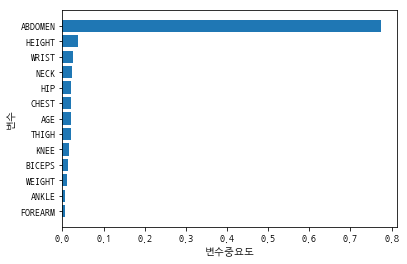

In [28]:
df_importance.sort_values('Importance', ascending = True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('변수중요도')
plt.ylabel('변수')

> 복부둘레가 가장 큰 유의한 변수로 확인

In [ ]:
estimator = GradientBoostingRegressor(random_state = 1234)

#구하고자 하는 parameter와 범위
param_grid = {'criterion':['mse','friedman_mse', 'mae'],'max_features':['auto','sqrt','log2'],'learning_rate':para_lr,'max_depth':para_depth, 'min_samples_split':para_split, 'min_samples_leaf':para_leaf}

#설명력이 높은 최적 parameter 찾기
grid_gb = GridSearchCV(estimator, param_grid, scoring = 'r2', n_jobs=-1)
grid_gb.fit(df_train_x, df_train_y)

print('best estimator model: \n {}'.format(grid_gb.best_estimator_))
print('\n nbest parameter : \n {}'.format(grid_gb.best_params_))
print('\n best score: \n {}'.format(grid_gb.best_score_.round(3)))

/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
